# Examine Water Temperature Seasonality with FFTs and statsmodels

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrahnis/nb-streamgage/blob/main/Streamgage-03--Water-Temperature-Seasonality.ipynb)

## Setup and imports

In [1]:
# if the notebook is running in colab we'll get the data from github
HOST_IS_COLAB = 'google.colab' in str(get_ipython())

if HOST_IS_COLAB:
    path = 'https://github.com/mrahnis/nb-streamgage/blob/main'
    params = '?raw=true'
else:
    path = '.'
    params = ''

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
favorites = {'01576516':'east branch',
         '015765185':'west branch',
         '015765195':'mainstem',
         '01576521':'mainstem-historical'}

gage = '015765195'

for key in favorites:
    print('https://waterdata.usgs.gov/monitoring-location/{}/'.format(key))

https://waterdata.usgs.gov/monitoring-location/01576516/
https://waterdata.usgs.gov/monitoring-location/015765185/
https://waterdata.usgs.gov/monitoring-location/015765195/
https://waterdata.usgs.gov/monitoring-location/01576521/


In [4]:
# streamgage data
df = pd.read_parquet('{}/data/nwis_{}_daily_all.parquet{}'.format(path, gage, params))

## Plotting the power spectral density

In [5]:
'''
drawing from this tutorial
https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/
'''

from scipy import fft

# fill with a fixed value
# df1.fillna(0, inplace=True)

# interpolate and then drop leading and trailing nans
ts = df['00010_Mean'].interpolate(method='linear').dropna()

# calculate the fft
ts_fft = fft.fft(ts.values).real

# calculate the power spectral density
ts_psd = np.abs(ts_fft) ** 2

freq = fft.fftfreq(len(ts_psd), 1. / 365)
i = freq > 0

In [6]:
# check for nans there should be none
np.any(np.isnan(ts_fft))

False

(0.0, 10.0)

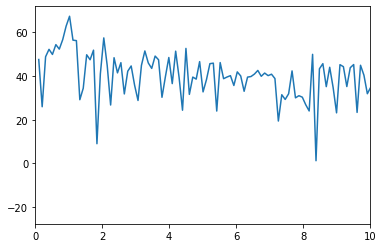

In [7]:
# plot the power spectral density
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(freq[i], 10 * np.log10(ts_psd[i]))
ax.set_xlim(0, 10)

## Isolate and reconstruct the dominant frequency


In [8]:
# remove the higher frequencies leaving those below 1.2 yr
ts_fft_bis = ts_fft.copy()
ts_fft_bis[np.abs(freq) > 1.2] = 0

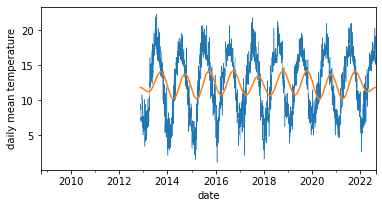

In [9]:
temp_slow = np.real(fft.ifft(ts_fft_bis))
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
df['00010_Mean'].plot(ax=ax, lw=.5)
ax.set_xlabel('date')
ax.set_ylabel('daily mean temperature')
ax.plot_date(ts.index, temp_slow, '-')

## Perform seasonal decomposition with the statsmodels package

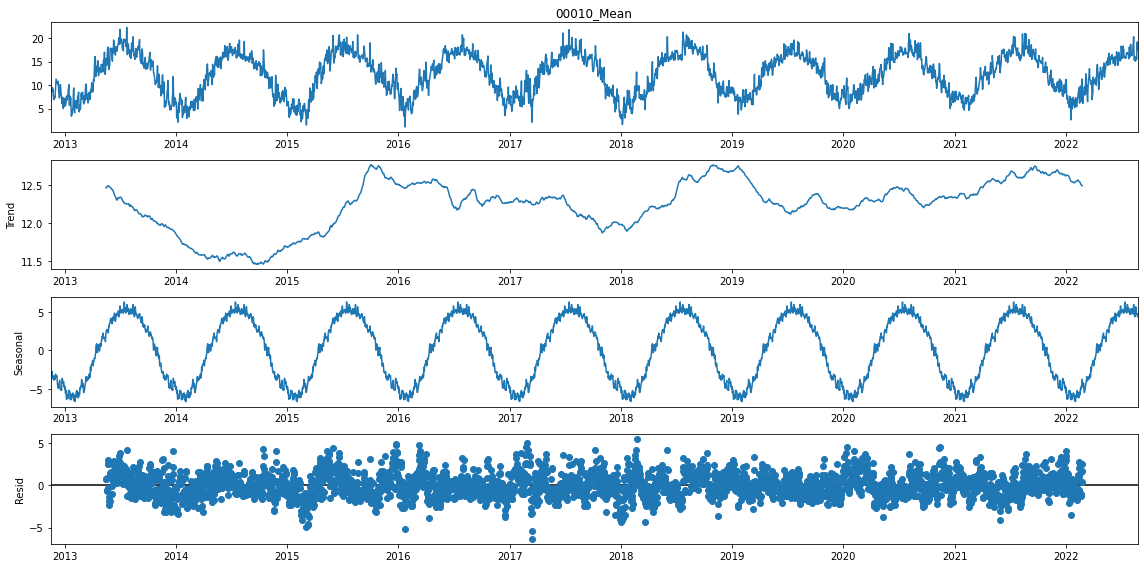

In [10]:
import statsmodels.api as sm

period = 365

plt.rc("figure", figsize=(16,8))
res = sm.tsa.seasonal_decompose(ts, period=period)
resplot = res.plot()